In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import glob
import anndata as ad

In [2]:
em1 = sc.read_10x_mtx('GSE166635_RAW/HCC1') 
em1.obs.index = ['HCC1_'+i for i in em1.obs.index]
em1.obs['sample'] = 'HCC1'
em1

AnnData object with n_obs × n_vars = 16077 × 33694
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [3]:
em2 = sc.read_10x_mtx('GSE166635_RAW/HCC2') 
em2.obs.index = ['HCC2_'+i for i in em2.obs.index]
em2.obs['sample'] = 'HCC2'
em2

AnnData object with n_obs × n_vars = 9112 × 33694
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [5]:
emall = ad.concat([em1,em2], merge='same')
emall.obs

,sample
HCC1_AAACCCAAGAAGAACG-1,HCC1
HCC1_AAACCCAAGCAACAAT-1,HCC1
HCC1_AAACCCAAGCATCTTG-1,HCC1
HCC1_AAACCCAAGCTGAGTG-1,HCC1
HCC1_AAACCCACAAGGGCAT-1,HCC1
...,...
HCC2_TTTGTTGCACTCGATA-1,HCC2
HCC2_TTTGTTGCAGCTTTCC-1,HCC2
HCC2_TTTGTTGGTTAGAAGT-1,HCC2
HCC2_TTTGTTGTCGCCTAGG-1,HCC2


In [7]:
emall.write('GSE166635_count.h5ad')

In [8]:
del emall

# ~

In [9]:
emcan = sc.read('GSE166635_count.h5ad')
emcan

AnnData object with n_obs × n_vars = 25189 × 33694
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

/data/hour/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


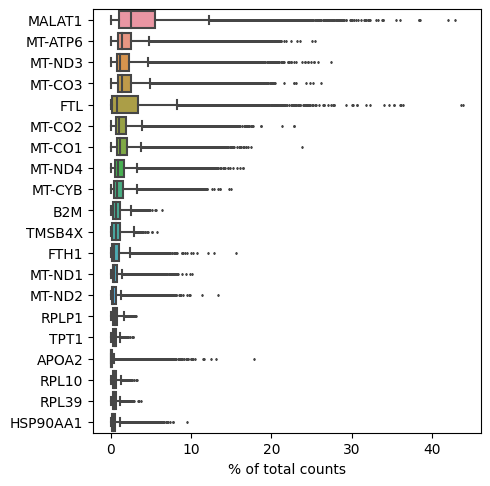

In [10]:
sc.pl.highest_expr_genes(emcan, n_top=20)

In [11]:
# fillter cells by gene and cell count
sc.pp.filter_cells(emcan, min_genes=200)
sc.pp.filter_genes(emcan, min_cells=5)
emcan

AnnData object with n_obs × n_vars = 24832 × 23085
    obs: 'sample', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'

In [12]:
# add info of the percentage of reads that map to the mitochondrial genome
emcan.var['mt'] = emcan.var_names.str.startswith('MT-')
# compute percentage of reads that map to the mitochondrial genome very efficiently.
sc.pp.calculate_qc_metrics(emcan, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

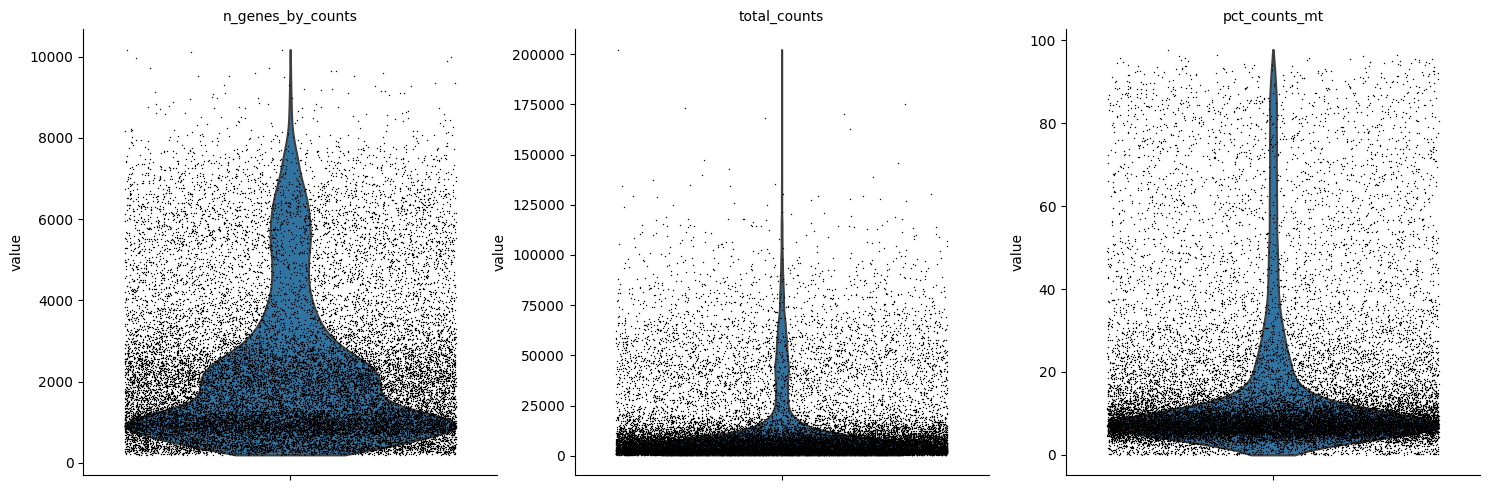

In [13]:
sc.pl.violin(emcan, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)

In [15]:
# keep high-quality data
#emcan = emcan[emcan.obs.n_genes_by_counts>500,:]
#emcan = emcan[emcan.obs.n_genes_by_counts<7000,:]
#emcan = emcan[emcan.obs.total_counts>500,:]
emcan = emcan[emcan.obs.total_counts<100000,:]
emcan = emcan[emcan.obs.pct_counts_mt<40,:]
#emcan = emcan[emcan.obs.pct_counts_hb<10,:]
emcan

View of AnnData object with n_obs × n_vars = 22341 × 23085
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [17]:
emcan.write('GSE166635_count.h5ad')

# ~

In [2]:
emcan = sc.read('GSE166635_count.h5ad')
emcan

AnnData object with n_obs × n_vars = 22341 × 23085
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [3]:
# total-count normalize (library-size correct) the data matrix 𝐗 to 1000,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(emcan, target_sum=1e6)
# logarithmize the data
sc.pp.log1p(emcan)
# save the result
emcan.raw = emcan

In [4]:
# extract top highly variable genes
sc.pp.highly_variable_genes(emcan, flavor='seurat', n_top_genes=2000, span=0.3, n_bins=20, min_mean=0.0125, max_mean=3, min_disp=0.5)
# actually do the filtering
emcan = emcan[:, emcan.var.highly_variable]
# regress out effects of total counts per cell, percentages of mitochondrial gene counts and heat shock protein (HSP) related gene counts 
sc.pp.regress_out(emcan, ['total_counts', 'pct_counts_mt'])
# scale data
sc.pp.scale(emcan, max_value=10)
# run dimensionality reduction
sc.pp.pca(emcan, svd_solver='arpack', n_comps=50)

/data/hour/miniconda3/lib/python3.8/site-packages/numba/core/dispatcher.py:289: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.22.4 (/data/hour/miniconda3/lib/python3.8/site-packages), Requirement.parse('numpy<1.22,>=1.18'), {'numba'}))'.
  entrypoints.init_all()


In [5]:
# perform Harmony using PCA results to adjust the PCs
sc.external.pp.harmony_integrate(emcan,'sample',basis='X_pca',adjusted_basis='X_pca_harmony')

2023-05-22 16:16:27,536 - harmonypy - INFO - Iteration 1 of 10
2023-05-22 16:16:33,933 - harmonypy - INFO - Iteration 2 of 10
2023-05-22 16:16:40,141 - harmonypy - INFO - Converged after 2 iterations


In [6]:
# perform BBKNN using Harmony results
sc.external.pp.bbknn(emcan,batch_key='sample',use_rep='X_pca_harmony',n_pcs=50)

2023-05-22 16:16:43.665803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 16:16:43.666530: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


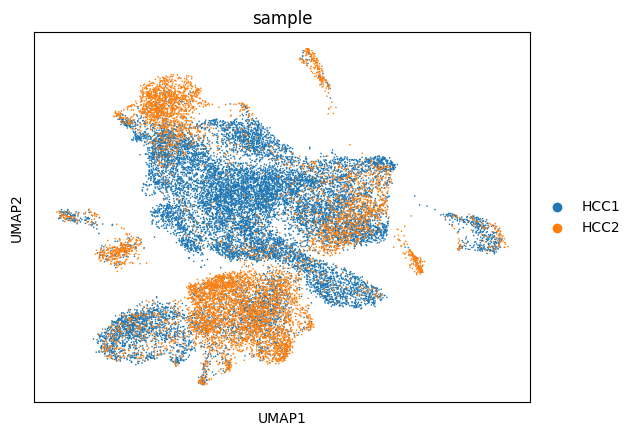

In [7]:
# obtain UMAP plot
sc.tl.umap(emcan)
sc.pl.umap(emcan,color=['sample'], ncols=2, palette=sc.pl.palettes.vega_20_scanpy)

/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


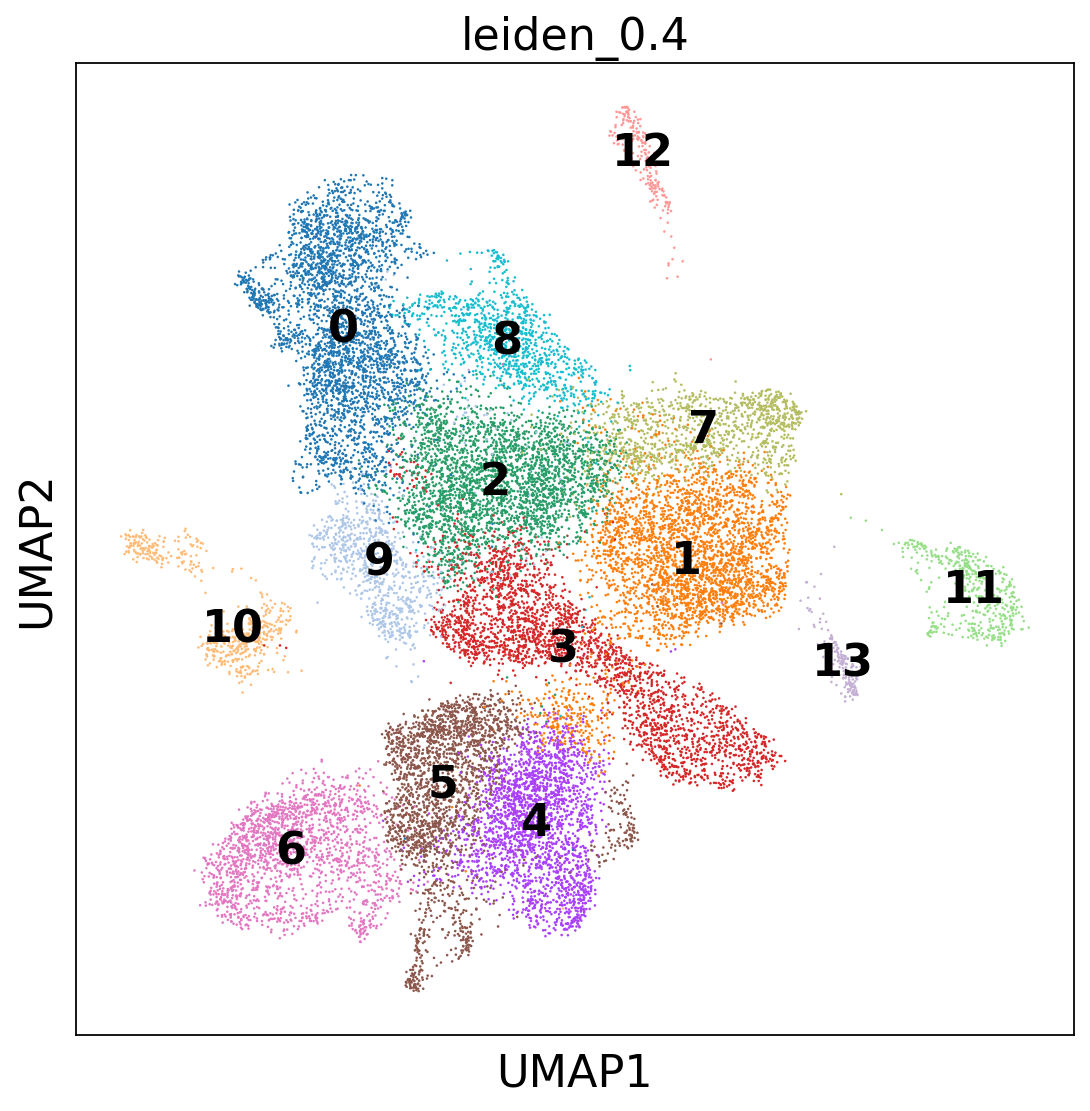

In [8]:
# leiden clustering
sc.tl.leiden(emcan,resolution=0.4,random_state=0,key_added='leiden_0.4')
# check the clusters on the UMAP
sc.settings.set_figure_params(fontsize=20,figsize=(8,8))
sc.pl.umap(emcan,color=['leiden_0.4'],legend_loc='on data',palette=sc.pl.palettes.vega_20_scanpy)

categories: 0, 1, 2, etc.
var_group_labels: T cells, B cells, LSECs, etc.


/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


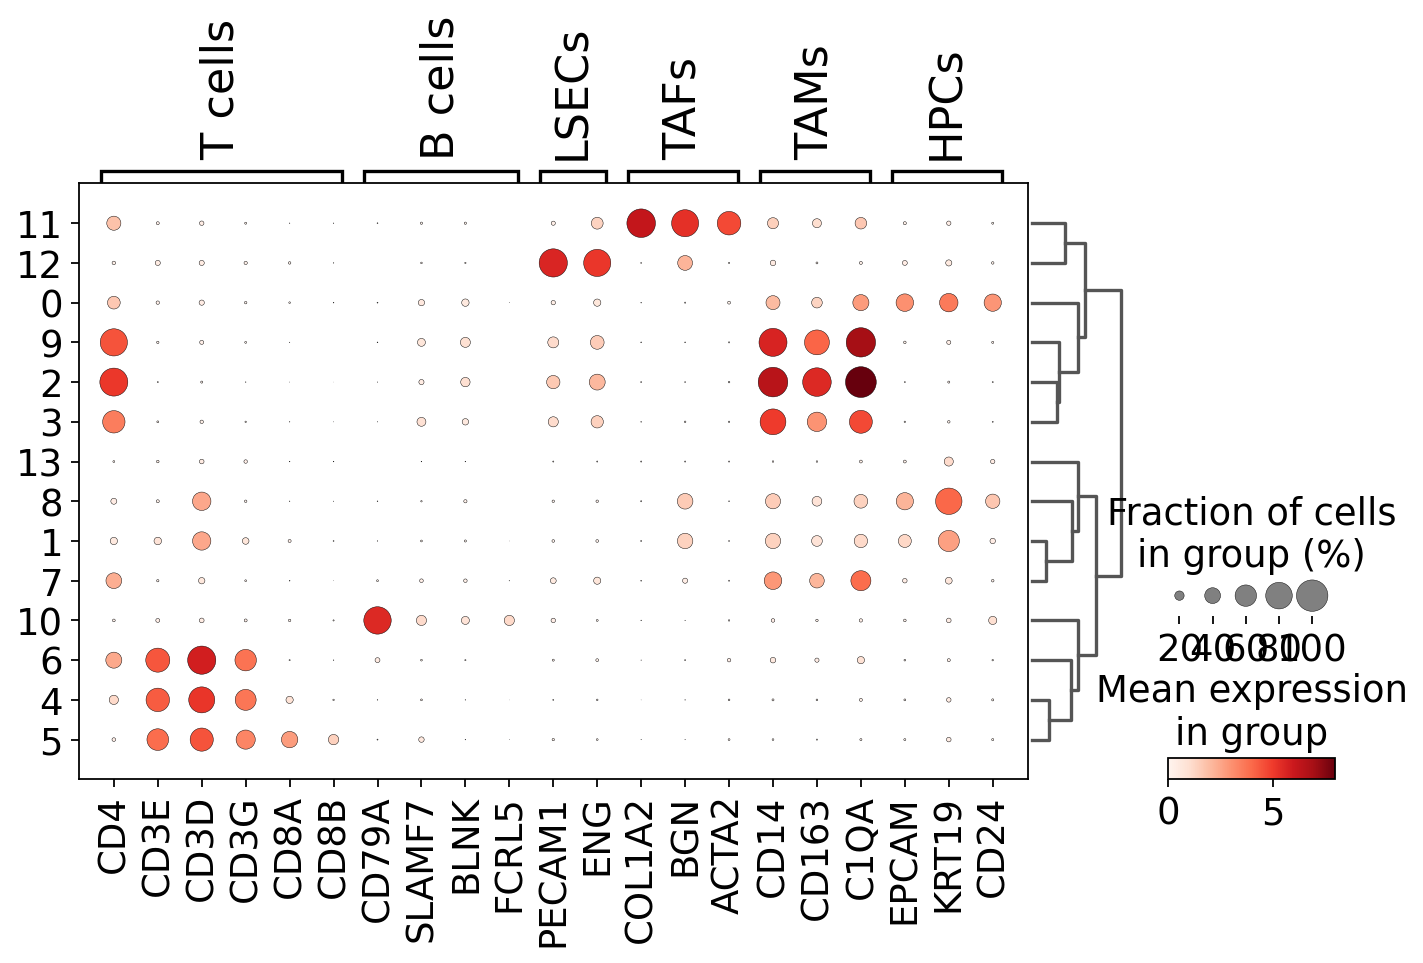

In [10]:
markerDict = {#13
'T cells': ['CD4', 'CD3E', 'CD3D', 'CD3G', 'CD8A', 'CD8B'],#4 5 6
'B cells': ['CD79A', 'SLAMF7', 'BLNK', 'FCRL5'],#10
'LSECs': ['PECAM1', 'ENG'],#12
'TAFs': ['COL1A2', 'BGN', 'ACTA2'],#11
'TAMs': ['CD14', 'CD163', 'C1QA'],#2 3 7 9
'HPCs': ['EPCAM', 'KRT19', 'CD24'],#0 1 8
}
sc.pl.dotplot(emcan, markerDict, groupby='leiden_0.4', dendrogram=True)

In [11]:
annDict = {
    '0':'HPCs',
    '1':'HPCs',
    '2':'TAMs',
    '3':'TAMs',
    '4':'T cells',
    '5':'T cells',
    '6':'T cells',
    '7':'TAMs',
    '8':'HPCs',
    '9':'TAMs',
    '10':'B cells',
    '11':'TAFs',
    '12':'LSECs',
    '13':'Others',
}
emcan.obs['cell type'] = [annDict[i] for i in emcan.obs['leiden_0.4']]

/data/hour/miniconda3/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


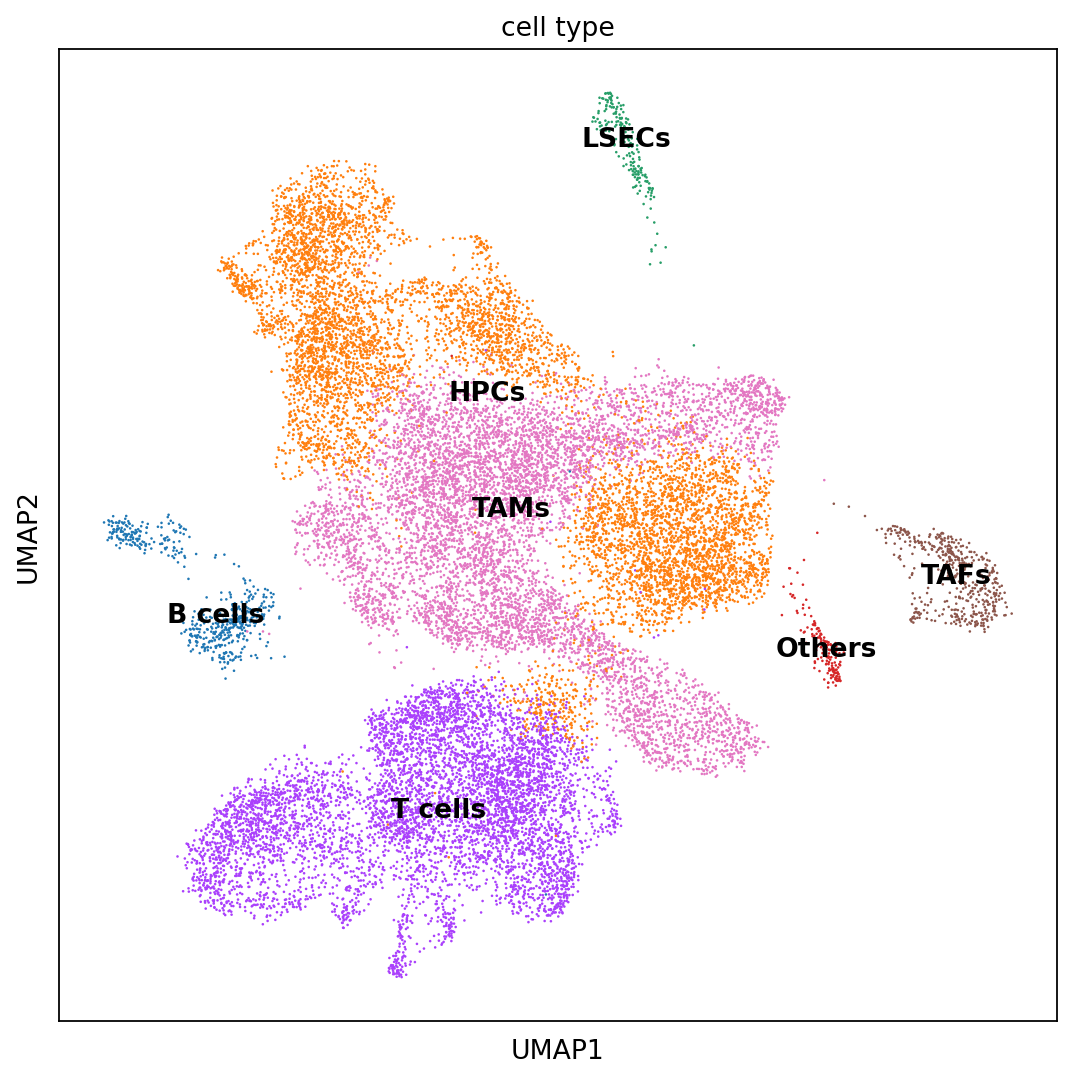

In [12]:
sc.settings.set_figure_params(fontsize=12, figsize=(8, 8))
sc.pl.umap(emcan,color=['cell type'],legend_loc='on data')

In [13]:
emcan.write('GSE166635_upm_log1p.h5ad')

In [14]:
emcan.obs.to_csv('GSE166635_obs.csv',index=True,header=True)